In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
path = "./archive/stemmed_cleaned_data.csv"

df = pd.read_csv(path, delimiter=",", quotechar='"')

print(df.head())

                              title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
1  Your Brain On Coronavirus\n\nA guide to the cu...   
2  Mind Your Nose\n\nHow smell training can chang...   
3  Passionate about the synergy between science a...   
4  You’ve heard of him, haven’t you? Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-y

In [3]:
# Prétraitement : Suppression des NaN et Transformation TF-IDF
tags = [
    "Blockchain", "Data Science", "Technology", "Programming", "Poetry",
    "Cryptocurrency", "Machine Learning", "Life", "Bitcoin", "Writing",
    "Politics", "Startup", "Life Lessons", "Self Improvement", "Covid 19",
    "Software Development", "Love", "Python", "Business", "Health",
    "Mental Health", "JavaScript", "Relationships", "Education",
    "Artificial Intelligence", "Culture", "Design", "Self", "Marketing",
    "Entrepreneurship", "Ethereum", "Music", "Productivity",
    "Web Development", "History", "Humor", "Data Visualization",
    "Leadership", "Social Media", "Psychology", "Travel", "Fiction",
    "Creativity", "Coronavirus", "Parenting", "Crypto", "Science",
    "Tech", "UX", "Short Story"
]

# Liste des 20 premiers tags
top_20_tags = tags[:20].copy()

#On ne garde que les article qui possent un des 20 tags séléctionnés

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filtrer le DataFrame pour ne garder que les articles avec ces tags
df = df[df['tags'].apply(lambda tags: any(tag in top_20_tags for tag in tags))].copy()

# On ne garde que le premier tag pour chaque article
df['main_tag'] = df['tags'].apply(lambda tags: next((tag for tag in tags if tag in top_20_tags), None))

# Supprime les lignes avec clean_text vide
df = df.dropna(subset=['clean_text'])  

print(df)

#tf-idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

                                                    title  \
0                                     Mental Note Vol. 24   
3                                The 4 Purposes of Dreams   
4                        Surviving a Rod Through the Head   
5       Mentally, Young Adults Are Suffering Most From...   
6       How to Turn Your Popular Blog Series Into a Be...   
...                                                   ...   
192333  [Live Stream] 2021 Soul Train Music Awards | F...   
192336  The global startup festival “COMEUP 2021” begi...   
192340  How To Deal with Loneliness in Festivals & Exp...   
192342                        Type 2 Diabetes on the Rise   
192343  The Concept of Stem Cells. Have you ever wonde...   

                                                     text  \
0       Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
3       Passionate about the synergy between science a...   
4       You’ve heard of him, haven’t you? Phineas Gage...   
5       Mentally, Young

In [4]:
#Réduction de Dimension avec LDA (LDA nécessite y catégorique)
y = df['main_tag'].astype('category').cat.codes  # Encodage des classes
lda = LDA(n_components=min(len(np.unique(y))-1, 19))  # LDA limité à nb_classes-1
X_lda = lda.fit_transform(X_tfidf.toarray(), y)

In [5]:
#  Test de plusieurs valeurs de k après sélection de features
k_values = [5, 10, 20, 50, 100, 500, 1000]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = np.mean(cross_val_score(knn, X_lda, y, cv=5, scoring='accuracy'))
    scores.append(score)
    print(f"k={k}, précision moyenne={score:.4f}")

# Sélection du meilleur k
best_k = k_values[np.argmax(scores)]
print(f"\nMeilleur k = {best_k} avec une précision de {max(scores):.4f}")

k=5, précision moyenne=0.5805
k=10, précision moyenne=0.6068
k=20, précision moyenne=0.6211
k=50, précision moyenne=0.6292
k=100, précision moyenne=0.6333
k=500, précision moyenne=0.6347
k=1000, précision moyenne=0.6322

Meilleur k = 500 avec une précision de 0.6347


In [6]:
# Entraînement du KNN optimal
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)


Métriques de Classification :
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       535
           1       0.61      0.74      0.67      1012
           2       0.57      0.57      0.57       548
           3       0.72      0.70      0.71       687
           4       0.56      0.44      0.49       666
           5       0.57      0.57      0.57       799
           6       0.77      0.67      0.72       586
           7       0.46      0.40      0.42       677
           8       0.51      0.44      0.48       744
           9       0.59      0.58      0.58       527
          10       0.68      0.75      0.71       925
          11       0.62      0.87      0.72      1037
          12       0.83      0.87      0.85       943
          13       0.59      0.74      0.66       864
          14       0.58      0.54      0.56       536
          15       0.51      0.54      0.52       632
          16       0.61      0.43      0.51       

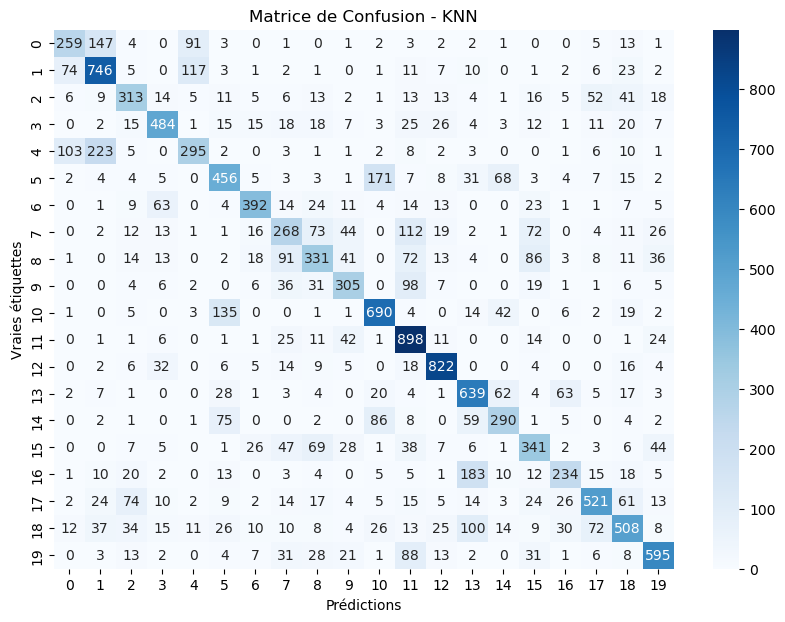

In [7]:
# Affichage des métriques et Matrice de Confusion
print("\nMétriques de Classification :")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion - KNN")
plt.show()

In [8]:
# Amélioration avec Bagging
bagging_knn = BaggingClassifier(estimator=knn_best, n_estimators=10, random_state=42)
bagging_knn.fit(X_train, y_train)
y_pred_bagging = bagging_knn.predict(X_test)

print("\nMétriques après Bagging :")
print(classification_report(y_test, y_pred_bagging))



Métriques après Bagging :
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       535
           1       0.61      0.74      0.67      1012
           2       0.56      0.57      0.57       548
           3       0.72      0.70      0.71       687
           4       0.56      0.44      0.49       666
           5       0.57      0.57      0.57       799
           6       0.77      0.67      0.71       586
           7       0.46      0.40      0.43       677
           8       0.51      0.45      0.48       744
           9       0.59      0.58      0.58       527
          10       0.68      0.74      0.71       925
          11       0.62      0.87      0.72      1037
          12       0.83      0.87      0.85       943
          13       0.59      0.74      0.66       864
          14       0.58      0.55      0.56       536
          15       0.51      0.53      0.52       632
          16       0.60      0.43      0.50       541
